In [1]:
from pathlib import Path
import datetime
import pandas as pd
from matplotlib import pylab as plt
from pymongo import MongoClient

# Load data
Step 0 is pulling events with the Sentry API

In [2]:
def load_event(event_name, unique=True):
    db = MongoClient().fmriprep_stats
    data = pd.DataFrame(list(db[event_name].find()))
    
    if len(data) == 0:
        raise RuntimeError(f"No records of event '{event_name}'")
    data.dateCreated = pd.to_datetime(data.dateCreated)
    data["date_minus_time"] = data["dateCreated"].apply(
        lambda df: datetime.datetime(year=df.year, month=df.month, day=df.day)
    )
    if unique is True:
        return data.drop_duplicates(subset=['run_uuid'])
    return data

## Processing "started" event

In [3]:
unique_started = load_event("started")
grouped_started = unique_started.groupby([
    unique_started['date_minus_time'].dt.isocalendar().year,
    unique_started['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_started

year  week
2022  36       1181
      37       7276
      38       5302
      39       8507
      40       5774
      41       7273
      42       6472
      43       6744
      44       7336
      45       7588
      46      10381
      47       7658
      48       8155
      49       8925
      50       7722
      51       8864
      52       5191
2023  1        2083
Name: id, dtype: int64

## Processing "success" event

In [4]:
unique_success = load_event("success")
grouped_success = unique_success.groupby([
    unique_success['date_minus_time'].dt.isocalendar().year,
    unique_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_success

year  week
2022  36       672
      37      4709
      38      4004
      39      5765
      40      4237
      41      4909
      42      4442
      43      4352
      44      4904
      45      5026
      46      8420
      47      5877
      48      6184
      49      6591
      50      4902
      51      6715
      52      3824
2023  1       1521
Name: id, dtype: int64

In [5]:
unique_started_success = unique_success.loc[unique_success['run_uuid'].isin(unique_started['run_uuid'])]
grouped_started_success = unique_started_success.groupby([
    unique_started_success['date_minus_time'].dt.isocalendar().year,
    unique_started_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()

In [6]:
versions = sorted(unique_started["environment_version"].fillna("n/a").unique())[-12:]
versions

['22.0.0',
 '22.0.0rc0',
 '22.0.0rc1',
 '22.0.0rc2',
 '22.0.0rc3',
 '22.0.0rc4',
 '22.0.1',
 '22.0.2',
 '22.1.0',
 '22.1.1',
 'n/a',
 'v0.0.1']

In [7]:
versions_success = {}
versions_started = {}

for version in versions:
    ver_suc = unique_started_success[unique_started_success['environment_version'] == version]
    ver_sta = unique_started[unique_started['environment_version'] == version]
    
    versions_success[version] = ver_suc.groupby([
        ver_suc['date_minus_time'].dt.isocalendar().year,
        ver_suc['date_minus_time'].dt.isocalendar().week,
    ])['id'].count()
    versions_started[version] = ver_sta.groupby([
        ver_sta['date_minus_time'].dt.isocalendar().year,
        ver_sta['date_minus_time'].dt.isocalendar().week,
    ])['id'].count()

versions_success = pd.DataFrame(versions_success)
versions_started = pd.DataFrame(versions_started)


## Successful runs per week

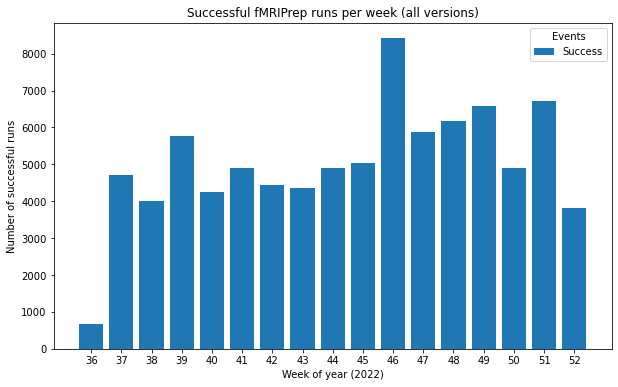

In [8]:
fig,ax = plt.subplots(figsize=(10, 6))
indexes = [f"{w}" for _, w in grouped_success.index[:-1]]
ax.bar(indexes, grouped_success.values[:-1], width=0.8, label='Success')
# ax.bar(indexes + 0.2, grouped_started_success.values[:-1], width=0.4,
#        label='Started+Success')

plt.ylabel("Number of successful runs")
plt.xlabel("Week of year (2022)")
plt.title("Successful fMRIPrep runs per week (all versions)")
plt.legend(bbox_to_anchor=(1, 1), title='Events');
plt.savefig('20221206_successful_weekly_abs.png', dpi=300, bbox_inches='tight')

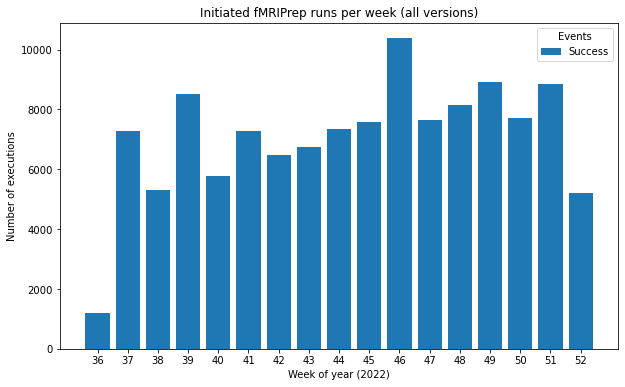

In [9]:
fig,ax = plt.subplots(figsize=(10, 6))
indexes = [f"{w}" for _, w in grouped_started.index[:-1]]
ax.bar(indexes, grouped_started.values[:-1], width=0.8, label='Success')
# ax.bar(indexes + 0.2, grouped_started_success.values[:-1], width=0.4,
#        label='Started+Success')

plt.ylabel("Number of executions")
plt.xlabel("Week of year (2022)")
plt.title("Initiated fMRIPrep runs per week (all versions)")
plt.legend(bbox_to_anchor=(1, 1), title='Events');
plt.savefig('20221206_all_weekly_abs.png', dpi=300, bbox_inches='tight')

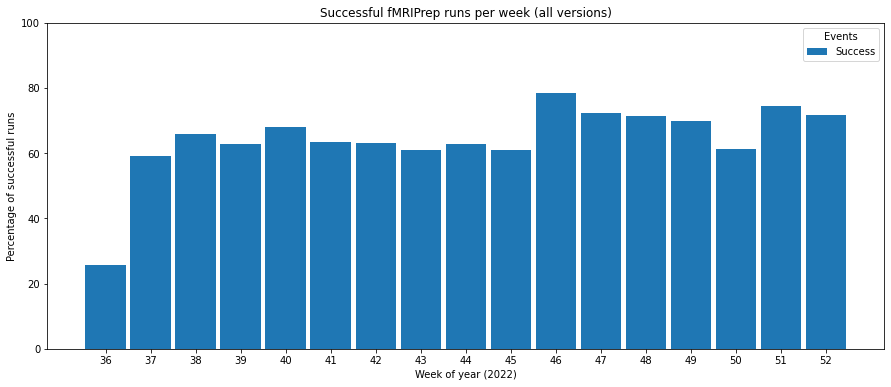

In [10]:
fig,ax = plt.subplots(figsize=(15, 6))
ax.bar(indexes, (grouped_started_success.values[:-1] / grouped_started.values[:-1]) * 100,
       width=0.9, label='Success')

plt.ylabel("Percentage of successful runs")
plt.xlabel("Week of year (2022)")
plt.title("Successful fMRIPrep runs per week (all versions)")
ax.set_ylim((0,100))
plt.legend(bbox_to_anchor=(1, 1), title='Events');
plt.savefig('20221206_successful_weekly_rel.png', dpi=300, bbox_inches='tight')

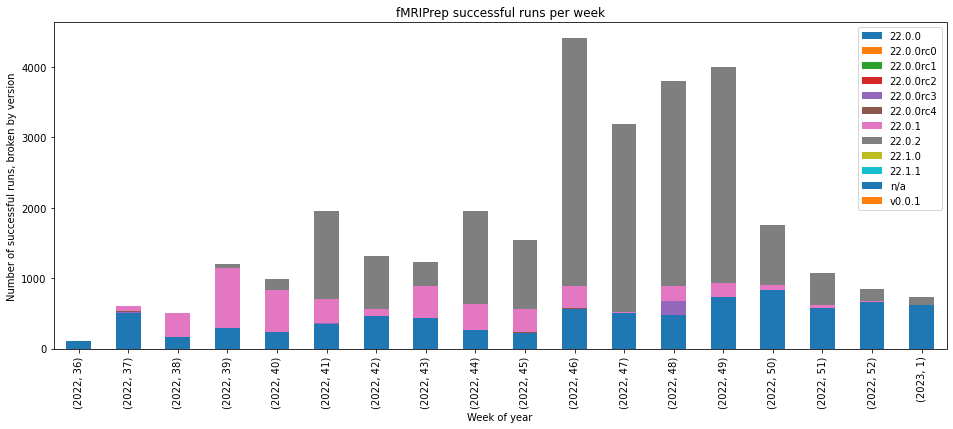

In [11]:
fig,ax = plt.subplots(figsize=(16,6))
ax = versions_success.plot.bar(stacked=True, ax=ax)

plt.ylabel("Number of successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_abs.png', dpi=300, bbox_inches='tight')

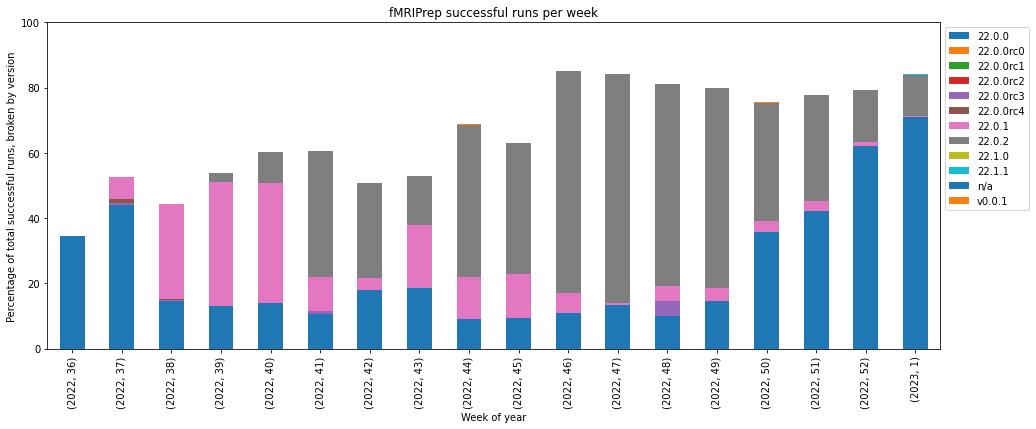

In [12]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.T / versions_started.sum(axis=1)).T * 100).plot.bar(stacked=True, ax=ax)

ax.set_ylim((0,100))
plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_total.png', dpi=300, bbox_inches='tight')

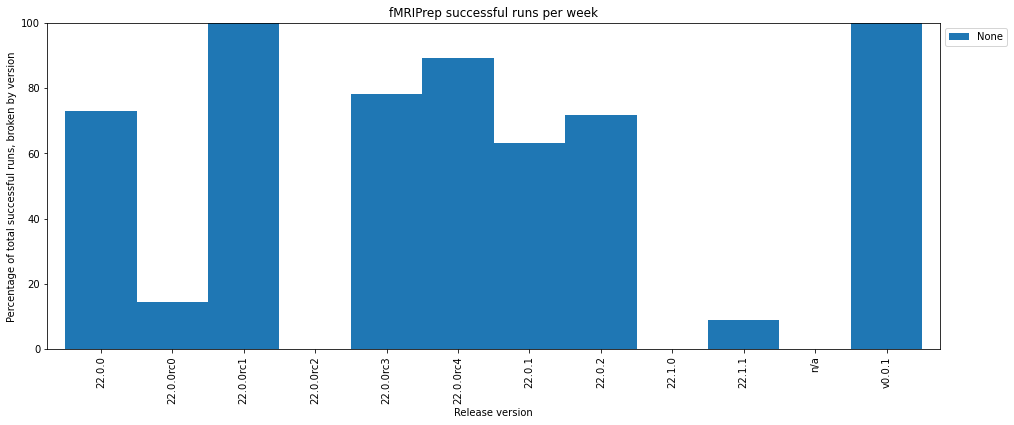

In [13]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.sum(axis=0) / versions_started.sum(axis=0)) * 100).plot.bar(ax=ax, width=1.0)

ax.set_ylim((0,100))

plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Release version")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_broken.png', dpi=300, bbox_inches='tight')

In [14]:
versions_success.sum(axis=0)

22.0.0        7978.0
22.0.0rc0        2.0
22.0.0rc1        1.0
22.0.0rc2        0.0
22.0.0rc3      238.0
22.0.0rc4       42.0
22.0.1        4303.0
22.0.2       18603.0
22.1.0           0.0
22.1.1           3.0
n/a              0.0
v0.0.1           8.0
dtype: float64

In [15]:
versions_started.sum(axis=0)

21.0.4        2026.0
22.0.0        9026.0
22.0.0rc0       13.0
22.0.0rc1        1.0
22.0.0rc2        3.0
22.0.0rc3      304.0
22.0.0rc4       47.0
22.0.1        6770.0
22.0.2       24871.0
22.1.0           2.0
n/a              0.0
v0.0.1           8.0
dtype: float64